# Generating images with variational autoencoders

In [77]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras
import numpy as np

from keras.datasets import mnist
from keras import layers
from keras import backend as K
from keras.models import Model

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1',
 '/job:localhost/replica:0/task:0/device:GPU:2']

## Loading the MNIST Dataset

In [57]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

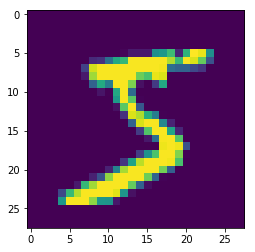

In [58]:
imgplot = plt.imshow(x_train[0,:,:])

## VAE Encoder Network

In [59]:
img = x_train[0,:,:]
img_shape = (img.shape[0], img.shape[1], 1)
batch_size = 16
latent_dim = 2
input_img = keras.Input(shape=img_shape)

In [60]:
x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

In [61]:
shape_before_flattening

(None, 14, 14, 64)

In [62]:
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

In [63]:
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

## Latent-space-sampling function

In [64]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon
z = layers.Lambda(sampling)([z_mean, z_log_var])

## VAE decoder network, mapping latent space points to images

In [66]:
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3,
                           padding='same',
                           activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same',
                  activation='sigmoid')(x)

In [67]:
decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [68]:
z_decoded

<tf.Tensor 'model_3/conv2d_13/Sigmoid:0' shape=(?, ?, ?, 1) dtype=float32>

In [70]:
class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded) 
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

In [ ]:
y = CustomVariationalLayer()([input_img, z_decoded])

## Training the VAE

In [72]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_12 

/home/jhooge/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Output "custom_variational_layer_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_2" during training.
  


In [73]:
(x_train, _), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))
vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 40s 663us/step - loss: 11923366.6605 - val_loss: 0.2038
Epoch 2/10
60000/60000 [==============================] - 30s 497us/step - loss: 0.1983 - val_loss: 0.1959
Epoch 3/10
60000/60000 [==============================] - 30s 494us/step - loss: 0.1917 - val_loss: 0.1887
Epoch 4/10
60000/60000 [==============================] - 30s 502us/step - loss: 0.1881 - val_loss: 0.1863
Epoch 5/10
60000/60000 [==============================] - 30s 493us/step - loss: 0.1858 - val_loss: 0.1843
Epoch 6/10
60000/60000 [==============================] - 30s 500us/step - loss: 0.1841 - val_loss: 0.1844
Epoch 7/10
60000/60000 [==============================] - 30s 497us/step - loss: 0.1829 - val_loss: 0.1828
Epoch 8/10
60000/60000 [==============================] - 30s 496us/step - loss: 0.1821 - val_loss: 0.1823
Epoch 9/10
60000/60000 [==============================] - 30s 494us/step - loss: 0.1811

## Sampling a grid of points from the 2D latent space and decoding them to images

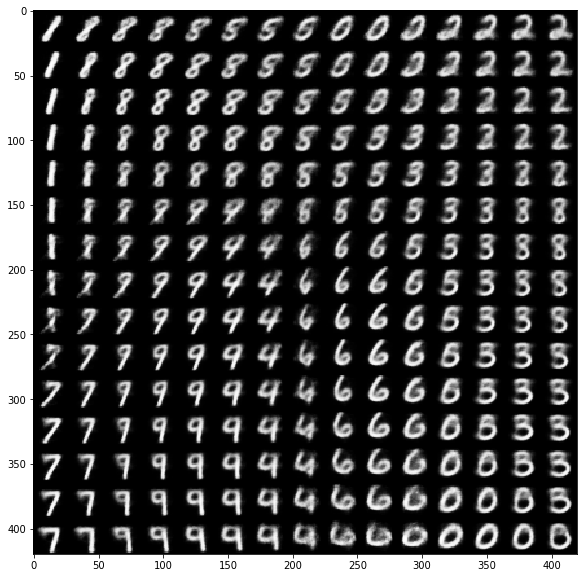

In [76]:
import matplotlib.pyplot as plt
from scipy.stats import norm

n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
        
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()